In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

import time

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/dataset_final_ncr_sm.csv')

In [5]:
dataset.shape

(2957263, 38)

In [6]:
X = dataset.iloc[:,0:36]
X.shape

(2957263, 36)

In [7]:
X.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz',
       'res_bdy_len', 'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'synack',
       'ackdat', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_src_ltm'],
      dtype='object')

In [0]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
# Pass parameter type = 'statistical' or 'minmax'
# Note: statistical is better for SVM and KNN.
def normalization(data, type='minmax'):
    if type == 'statistical':
        return stats.zscore(data)
    elif type == 'minmax':
        scaler = MinMaxScaler()
        return scaler.fit_transform(data)
    else:
        print('\n Norm type not found! \n')

In [0]:
X = normalization(X, 'statistical')

In [10]:
y = dataset.iloc[:,-2:]
y.shape

(2957263, 2)

In [11]:
y_attack_cat = dataset.iloc[:,-2]
y_attack_cat.shape

(2957263,)

In [0]:
def plot_roc(y_pred_val, y_testlb_val, y_predlb_val, classifier,count):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(np.unique(y_pred_val))):
    fpr[i], tpr[i], _ = roc_curve(y_testlb_val[:, i], y_predlb_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  n_classes = len(np.unique(y_pred_val))
  print('n_classes',n_classes)
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Plot all ROC curves
  plt.figure()
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristics '+classifier)
  plt.legend(loc="lower right")
  plt.savefig('ROC '+classifier+' '+str(count)+'.png')
  plt.show()
  plt.clf()



TRAIN: [      3       4       8 ... 2957257 2957258 2957259] TEST: [      0       1       2 ... 2957260 2957261 2957262]
n_classes 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


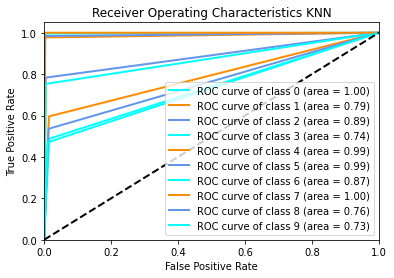

ROC SCORE:
 0.8755070455008873
F1 SCORE:
 0.9315333362188833
TRAIN: [      0       1       2 ... 2957260 2957261 2957262] TEST: [      3       4       8 ... 2957257 2957258 2957259]
n_classes 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


<Figure size 432x288 with 0 Axes>

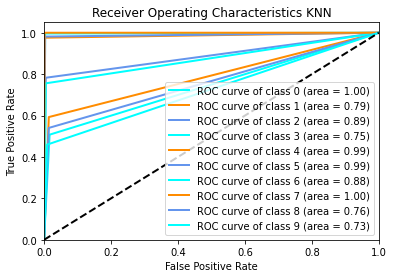

ROC SCORE:
 0.875980040569595
F1 SCORE:
 0.9318322150692093


<Figure size 432x288 with 0 Axes>

In [13]:
skf = StratifiedKFold(n_splits=2,shuffle = True)
time_knn = []
cv_score_roc_knn = []
cv_score_f1_knn = []
y_pred_knn_all = []
y_test_knn_all = []

count = 1
for train_index, test_index in skf.split(X, y_attack_cat):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_attack_cat[train_index], y_attack_cat[test_index]
    
    s = time.clock()
    
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train,y_train)
    y_pred = knn_model.predict(X_test)

    lb = preprocessing.LabelBinarizer()
    y_testlb = lb.fit_transform(y_test)
    y_predlb = lb.fit_transform(y_pred)
    
    e = time.clock() - s
    time_knn.append(e)
    
    y_pred_knn_all.append(y_pred)
    y_test_knn_all.append(y_test)
    
    plot_roc(y_pred, y_testlb, y_predlb, 'KNN',count)
    count +=1

    roc_score = roc_auc_score(y_testlb,y_predlb)
    print('ROC SCORE:\n',roc_score)   
    cv_score_roc_knn.append(roc_score)
    f1score = f1_score(y_testlb, y_predlb, average='micro')
    print('F1 SCORE:\n',f1score)
    #print('CONFUSION MATRIX:\n',confusion_matrix(y_testlb, y_predlb))
    cv_score_f1_knn.append(f1score)



In [19]:
print('time knn ',time_knn)

time knn  [5873.880292, 8646.241245000001]


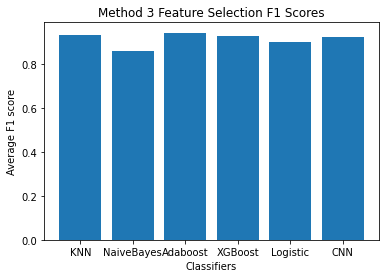

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

data = [0.9316,0.8618,0.943,0.9288,0.90,0.924]
plt.title('Method 3 Feature Selection F1 Scores')
plt.xlabel('Classifiers')
plt.ylabel('Average F1 score')
plt.bar(['KNN','NaiveBayes','Adaboost','XGBoost','Logistic','CNN'], data)
plt.savefig('All F1.png')
plt.show()

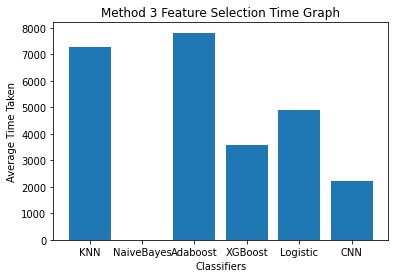

In [27]:
data = [7259,2.88,7812,3592,4899,2219]
plt.title('Method 3 Feature Selection Time Graph')
plt.xlabel('Classifiers')
plt.ylabel('Average Time Taken')
plt.bar(['KNN','NaiveBayes','Adaboost','XGBoost','Logistic','CNN'], data)
plt.savefig('All Times.png')
plt.show()